# Open Science Tutorial: Synthetic Data, Linear Regression, and Open-Science Concepts

This notebook is an educational example to learn four core concepts in open science:

- **Reproducibility (computational):** same data + same code + same random seed → **same numerical results**.
- **Replication:** new data from the **same (or very similar) design** + same analysis → **similar qualitative conclusion**.
- **Robustness (open-science sense):** same data + **different, reasonable analysis strategies** → **same qualitative conclusion**.
- **Generalization:** a model learned on some part of the data can **predict other data** (e.g. new participants).

We will use a simple **synthetic behavioral dataset**:

- Two groups: `control` vs `training`.
- Two trial types: `easy` vs `hard`.
- Outcome: **reaction time** in milliseconds, plus **accuracy** (correct / incorrect).

You can:
1. Run the cells to see the full example.
2. Try to complete and modify the code in the **Exercises** section at the end.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

sns.set(style="whitegrid")

# Global random seed for the main example
MASTER_SEED = 42
np.random.seed(MASTER_SEED)

print("Versions:")
print("  numpy:", np.__version__)
print("  pandas:", pd.__version__)

Versions:
  numpy: 2.2.6
  pandas: 2.3.3


## 1. Generating synthetic behavioral data

Imagine a **simple attention task**:

- Participants are randomly assigned to one of two groups:
  - `control`: no special training.
  - `training`: they receive a brief attention training.
- On each trial they see either an `easy` or `hard` stimulus.
- We measure:
  - `rt_ms`: reaction time in milliseconds,
  - `accuracy`: 1 = correct, 0 = incorrect.

We assume that, *on average*:

- The **training group** is faster than the control group.
- `hard` trials are slower and slightly less accurate than `easy` trials.
- Each participant has their own baseline speed (some people are generally faster/slower).

In [2]:
def generate_synthetic_data(
    n_subjects=60,
    n_trials_per_subject=40,
    seed=MASTER_SEED,
):
    """Generate a synthetic behavioral dataset for an attention task.

    Parameters
    ----------
    n_subjects : int
        Number of participants.
    n_trials_per_subject : int
        Number of trials per participant.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    data : pandas.DataFrame
        Long-format trial-level data with columns:
        subject_id, group, difficulty, rt_ms, accuracy, group_code.
    """
    rng = np.random.default_rng(seed)

    subject_ids = np.arange(1, n_subjects + 1)
    groups = rng.choice(["control", "training"], size=n_subjects, replace=True)

    # Subject-level random intercepts (baseline speed differences)
    subj_intercepts = rng.normal(loc=0, scale=40, size=n_subjects)

    rows = []
    for subj_id, group, intercept in zip(subject_ids, groups, subj_intercepts):
        for _ in range(n_trials_per_subject):
            difficulty = rng.choice(["easy", "hard"])

            # Data-generating model for reaction time
            base_rt = 550  # baseline RT in ms
            group_effect = -60 if group == "training" else 0      # training makes you faster
            difficulty_effect = 0 if difficulty == "easy" else 90 # hard trials are slower

            noise = rng.normal(loc=0, scale=60)

            rt_ms = base_rt + group_effect + difficulty_effect + intercept + noise

            # Accuracy model
            if difficulty == "easy":
                p_correct = 0.96 if group == "training" else 0.93
            else:  # hard
                p_correct = 0.90 if group == "training" else 0.85

            accuracy = rng.binomial(1, p_correct)

            rows.append({
                "subject_id": subj_id,
                "group": group,
                "difficulty": difficulty,
                "rt_ms": rt_ms,
                "accuracy": accuracy,
            })

    data = pd.DataFrame(rows)
    data["group_code"] = (data["group"] == "training").astype(int)
    return data


data = generate_synthetic_data()
data.head()

,subject_id,group,difficulty,rt_ms,accuracy,group_code
0,1,control,easy,629.756775,1,0
1,1,control,easy,630.882811,1,0
2,1,control,hard,646.303927,0,0
3,1,control,easy,659.652358,1,0
4,1,control,easy,713.619602,1,0


### Inspect the dataset

In [3]:
print("Shape:", data.shape)
print("\nFirst rows:")
display(data.head())

print("\nUnique subjects per group:")
print(data.groupby("group")["subject_id"].nunique())

print("\nOverall accuracy:")
print(data["accuracy"].mean())

Shape: (2400, 6)

First rows:


,subject_id,group,difficulty,rt_ms,accuracy,group_code
0,1,control,easy,629.756775,1,0
1,1,control,easy,630.882811,1,0
2,1,control,hard,646.303927,0,0
3,1,control,easy,659.652358,1,0
4,1,control,easy,713.619602,1,0



Unique subjects per group:
group
control     27
training    33
Name: subject_id, dtype: int64

Overall accuracy:
0.9183333333333333


## 2. Visualizing reaction times

First, let us visualize reaction times for each group and difficulty level using boxplots.

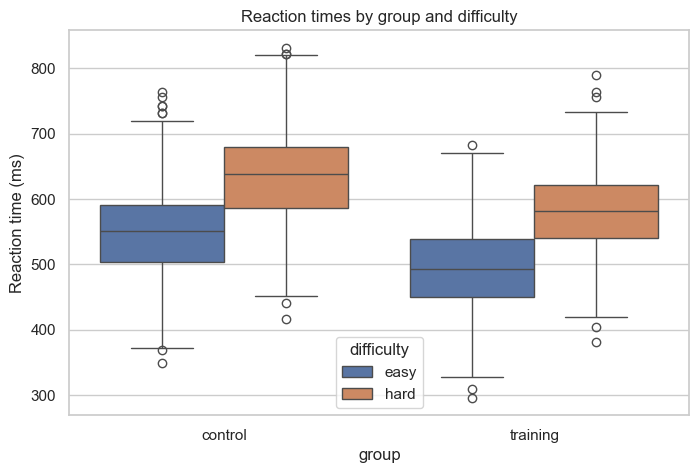

In [4]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x="group", y="rt_ms", hue="difficulty")
plt.title("Reaction times by group and difficulty")
plt.ylabel("Reaction time (ms)")
plt.show()

## 3. Linear regression: does training reduce reaction time?

We fit a simple **linear regression model** at the trial level:

\begin{align}
\text{rt\_ms} = \beta_0 + \beta_1 \cdot \text{group\_code} + \beta_2 \cdot I(\text{difficulty} = \text{hard}) + \epsilon
\end{align}

- `group_code = 0` for control, `1` for training.
- `difficulty` is a categorical predictor.
- If training makes participants faster, we expect **\(\beta_1 < 0\)**.

In [5]:
model = smf.ols("rt_ms ~ group_code + C(difficulty)", data=data).fit()
model

### Model-predicted means

We now compute and plot the *predicted* mean reaction times by group and difficulty according to the fitted model.

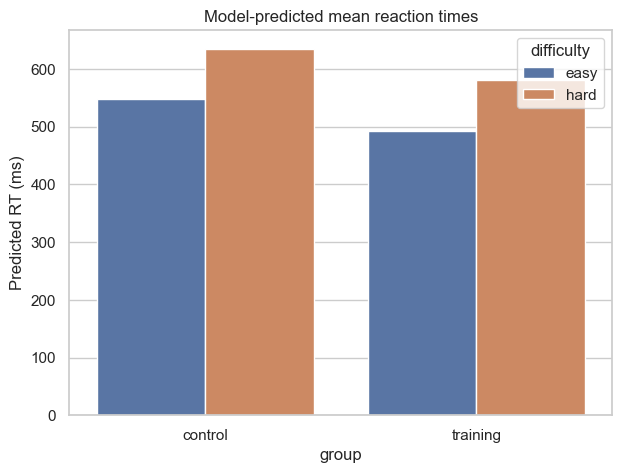

,group_code,difficulty,group,rt_pred
0,0,easy,control,548.118392
1,0,hard,control,635.421189
2,1,easy,training,493.394266
3,1,hard,training,580.697063


In [6]:
pred_df = pd.DataFrame({
    "group_code": [0, 0, 1, 1],
    "difficulty": ["easy", "hard", "easy", "hard"],
})
pred_df["group"] = np.where(pred_df["group_code"] == 1, "training", "control")
pred_df["rt_pred"] = model.predict(pred_df)

plt.figure(figsize=(7, 5))
sns.barplot(data=pred_df, x="group", y="rt_pred", hue="difficulty")
plt.ylabel("Predicted RT (ms)")
plt.title("Model-predicted mean reaction times")
plt.show()

pred_df

## 4. Reproducibility (computational)

**Reproducibility** in this narrow, computational sense means:

> Using the **same data**, **same code**, **same random seed**, and **same software** should produce **identical results**.

We now regenerate the dataset with the *same* seed and check that:

1. The data table is identical.
2. The regression coefficients are identical.


In [7]:
data_repeat = generate_synthetic_data(seed=MASTER_SEED)

print("Datasets identical (cell-by-cell)?", data.equals(data_repeat))

model_repeat = smf.ols("rt_ms ~ group_code + C(difficulty)", data=data_repeat).fit()
print("\nAre the regression coefficients identical?")
print(np.allclose(model.params.values, model_repeat.params.values))

model_repeat

Datasets identical (cell-by-cell)? True

Are the regression coefficients identical?
True


## 5. Replication: new sample, same analysis

A **replication study** uses:

- The *same* (or very similar) design,
- The *same* data-generating assumptions,
- The *same* analysis strategy,

but collects a **new sample of data**.

We simulate this by drawing a new synthetic dataset from the same process,  
but with a **different random seed**. We then refit the same regression and compare the coefficients.

In [8]:
REPLICATION_SEED = 123  # new seed for a new sample
data_replication = generate_synthetic_data(seed=REPLICATION_SEED)

print("Original sample size:", data.shape)
print("Replication sample size:", data_replication.shape)

model_replication = smf.ols("rt_ms ~ group_code + C(difficulty)", data=data_replication).fit()

print("Original coefficients:")
print(model.params)
print("\nReplication coefficients:")
print(model_replication.params)

Original sample size: (2400, 6)
Replication sample size: (2400, 6)
Original coefficients:
Intercept                548.118392
C(difficulty)[T.hard]     87.302797
group_code               -54.724126
dtype: float64

Replication coefficients:
Intercept                556.167154
C(difficulty)[T.hard]     90.663894
group_code               -73.195336
dtype: float64


## 6. Robustness (open-science sense): same data, different analysis strategies

In open-science discussions, **robustness** usually means:

> Testing whether a **prior finding** holds when we analyze the **same data**
> with **different, reasonable analysis strategies** (e.g. different preprocessing,
> different outcome scale, trial-level vs. subject-level model).

Here, the prior finding is: **training reduces reaction times** (negative coefficient for `group_code`).

We will do **two robustness checks**, all using the **same original dataset** `data`:

1. **Outlier handling:** compare models with and without removing extreme RTs.
2. **Outcome scale & aggregation:** compare a trial-level model vs. a subject-level model on mean RT.


### 6.1 Robustness to outlier handling

First, we fit:

- Model A: regression on **all** trials (no outlier removal).
- Model B: regression after removing extreme RTs (< 150 ms or > 1200 ms).

We then compare the training effect (`group_code` coefficient).

In [7]:
# Model A: all trials (already fitted as 'model')
coef_all = model.params

# Model B: remove extreme RTs
mask_non_outlier = (data["rt_ms"] >= 150) & (data["rt_ms"] <= 1200)
data_no_outliers = data[mask_non_outlier]
model_no_outliers = smf.ols("rt_ms ~ group_code + C(difficulty)", data=data_no_outliers).fit()
coef_no_outliers = model_no_outliers.params

print("Training coefficient (group_code):")
print("  All trials        :", coef_all["group_code"])
print("  Without outliers  :", coef_no_outliers["group_code"])

Training coefficient (group_code):
  All trials        : -54.72412637470951
  Without outliers  : -54.72412637470951


### 6.2 Robustness to aggregation: trial-level vs subject-level model

Next, we compare:

- Model C: **trial-level** model (our original model).
- Model D: **subject-level** model, using each participant's mean RT across all trials.

If the training effect is robust, we should see a similar direction (and maybe similar magnitude)  
for the training coefficient in both models.

In [8]:
# Subject-level means
subject_means = (
    data.groupby(["subject_id", "group", "group_code"], as_index=False)["rt_ms"]
    .mean()
    .rename(columns={"rt_ms": "rt_mean"})
)

model_subject = smf.ols("rt_mean ~ group_code", data=subject_means).fit()

print("Trial-level model coefficient for training (group_code):", model.params["group_code"])
print("Subject-level model coefficient for training (group_code):", model_subject.params["group_code"])

Trial-level model coefficient for training (group_code): -54.72412637470951
Subject-level model coefficient for training (group_code): -55.56922920728144


## 7. Generalization: can the model predict new participants?

A simple way to think about **generalization** is to ask:

> If we fit a model on some participants, how well does it predict **other** participants?

We will do a very simple **train/test split by subject**:

1. Randomly assign half of the subjects to a **training set** and half to a **test set**.
2. Fit the regression model on the training set.
3. Use the model to predict RTs for the test set.
4. Compute an error measure (mean absolute error, MAE).

In [9]:
rng = np.random.default_rng(999)
unique_subj = data["subject_id"].unique()
rng.shuffle(unique_subj)

half = len(unique_subj) // 2
train_ids = unique_subj[:half]
test_ids = unique_subj[half:]

train_data = data[data["subject_id"].isin(train_ids)]
test_data = data[data["subject_id"].isin(test_ids)]

print("Train subjects:", len(train_ids))
print("Test subjects :", len(test_ids))

# Fit on training set
model_train = smf.ols("rt_ms ~ group_code + C(difficulty)", data=train_data).fit()

# Predict on test set
test_data = test_data.copy()
test_data["rt_pred"] = model_train.predict(test_data)

mae = np.abs(test_data["rt_ms"] - test_data["rt_pred"]).mean()
print("Mean absolute error on held-out subjects:", mae)

Train subjects: 30
Test subjects : 30
Mean absolute error on held-out subjects: 54.958747541654326


## 8. Exercises – one per concept

Each exercise below targets exactly one open-science concept. The tasks are small and guided so you can complete them quickly.

- **Exercise 1:** Reproducibility (same data + same code).
- **Exercise 2:** Reproduction (new data, same design).
- **Exercise 3:** Robustness (alternative but reasonable analysis).
- **Exercise 4:** Generalization (train/test split).


### Exercise 1 – Reproducibility (computational)

Goal: show that **same seed + same code = same numbers**.

Steps:
1. Regenerate the dataset with the same `MASTER_SEED`.
2. Check that the new table matches `data` exactly.
3. Fit the regression again and confirm all coefficients match the original `model`.


In [ ]:
# EXERCISE 1: Reproducibility
# TODO:
# 1. Regenerate the dataset with the original seed.
# 2. Compare the new data to `data`.
# 3. Refit the regression and compare coefficients.

# Example starter code (you can change/expand it):
data_same_seed = generate_synthetic_data(seed=MASTER_SEED)
print("Datasets identical?", data.equals(data_same_seed))

model_same_seed = smf.ols("rt_ms ~ group_code + C(difficulty)", data=data_same_seed).fit()
print("Coefficients match?", model.params.equals(model_same_seed.params))


### Exercise 2 – Reproduction (new data, same design)

Goal: collect a **new synthetic sample** with the same task design and see if the training effect points the same way.

Steps:
1. Pick a **different random seed** (e.g., `12345`).
2. Generate a new dataset with the same number of subjects and trials.
3. Fit `rt_ms ~ group_code + C(difficulty)` and extract the `group_code` coefficient and p-value.
4. Comment: do you still see evidence that training reduces RTs?


In [ ]:
# EXERCISE 2: Reproduction / replication
# TODO:
# 1. Choose a new seed value.
# 2. Generate a fresh dataset with the same design.
# 3. Fit the regression and inspect the training coefficient.

new_seed = 12345  # change if you want
data_new = generate_synthetic_data(seed=new_seed)
model_new = smf.ols("rt_ms ~ group_code + C(difficulty)", data=data_new).fit()
print(model_new.summary().tables[1])


### Exercise 3 – Robustness (different but reasonable analysis)

Goal: check whether the training effect survives a **simple analysis change** on the same data.

Try one of these options (or another reasonable choice):
- Model log-RTs instead of raw RTs.
- Remove extreme RTs (e.g., below 150 ms or above 1200 ms).

Steps:
1. Apply your chosen transformation/filter to `data`.
2. Fit the regression again.
3. Compare the sign and size of the training coefficient to the original model.


In [ ]:
# EXERCISE 3: Robustness check
# TODO:
# 1. Transform or filter `data` (e.g., log RTs or remove extremes).
# 2. Fit a new regression.
# 3. Compare the training effect with the original model.

# Example starting point (log-transform):
data_log = data.assign(log_rt=np.log(data["rt_ms"]))
model_log = smf.ols("log_rt ~ group_code + C(difficulty)", data=data_log).fit()
print(model_log.summary().tables[1])


### Exercise 4 – Generalization (train/test split by subject)

Goal: estimate how well the model predicts **new participants**.

Steps:
1. Split subjects into a training and test set (e.g., 50/50).
2. Fit the model on the training subjects only.
3. Predict RTs for the held-out subjects.
4. Compute and print the mean absolute error (MAE).
5. Optional: repeat with a different split to see how stable the error is.


In [ ]:
# EXERCISE 4: Generalization via train/test split
# TODO:
# 1. Create a subject-level train/test split.
# 2. Fit the model on training subjects.
# 3. Predict RTs for test subjects and compute MAE.

from sklearn.metrics import mean_absolute_error

rng = np.random.default_rng(123)
subjects = data["subject_id"].unique()
rng.shuffle(subjects)
mid = len(subjects) // 2
train_subjects = subjects[:mid]
test_subjects = subjects[mid:]

train_df = data[data["subject_id"].isin(train_subjects)]
test_df = data[data["subject_id"].isin(test_subjects)]

model_train = smf.ols("rt_ms ~ group_code + C(difficulty)", data=train_df).fit()
preds = model_train.predict(test_df)
mae = mean_absolute_error(test_df["rt_ms"], preds)
print(f"Test MAE: {mae:.2f} ms")
